In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [35]:
img = cv2.imread('/Users/ondra/dev/personal/siamese-registration/data/frame_sequences/Study_02_00007_01_L/0.jpg')
rows, cols, ch = img.shape
center = (img.shape[1]//2, img.shape[0]//2)
print(img.shape)

(770, 1000, 3)


## Rotation

In [4]:
angle = -10
scale = 1.0

M = cv2.getRotationMatrix2D( center, angle, scale )
print(M)

[[  0.98480775  -0.17364818  74.4506719 ]
 [  0.17364818   0.98480775 -80.97507374]]


In [5]:
dst = cv2.warpAffine(img,M,(cols,rows))

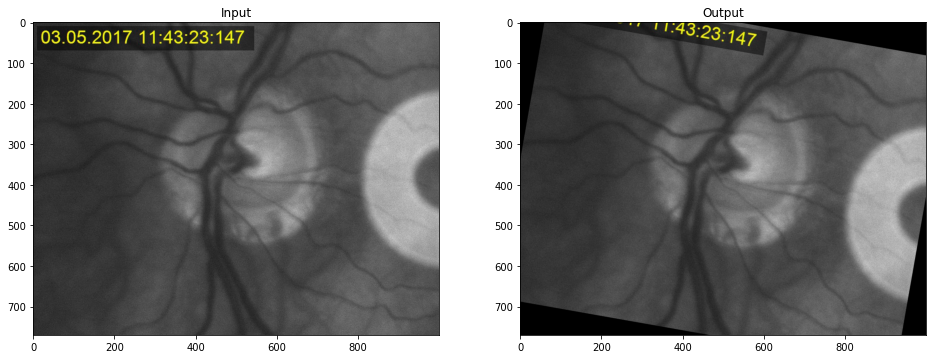

In [6]:
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(img)
plt.title('Input')
  
plt.subplot(122)
plt.imshow(dst)
plt.title('Output')
  
plt.show()

## Affine transformation

In [32]:
tx = np.random.uniform(-50, 50, 1)[0]
ty = np.random.uniform(-50, 50, 1)[0]
sx = np.random.uniform(0.95, 1.05, 1)[0]
sy = np.random.uniform(0.95, 1.05, 1)[0]
shx = np.random.uniform(-0.1, 0.1, 1)[0]
shy = np.random.uniform(-0.1, 0.1, 1)[0]
q = np.radians(np.random.uniform(-10, 10, 1)[0])

tx = 50
ty = -50
sx = 0.9
sy = 1.0
shx = -0.1
shy = 0.1
q = np.radians(-10)

print("params:")
print([tx, ty, sx, sy, shx, shy, q])


T_move_to_center = np.array([
    [1, 0, center[0]],
    [0, 1, center[1]],
    [0, 0, 1],
])

T_rotate = np.array([
    [np.cos(q), -
     
     np.sin(q), 0],
    [np.sin(q), np.cos(q), 0],
    [0, 0, 1]
])

T_translate = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1],
])

T_scale = np.array([
    [sx, 0, 0],
    [0, sy, 0],
    [0, 0, 1]
])

T_shear = np.array([
    [1, shy, 0],
    [shx, 1, 0],
    [0, 0, 1]
])

T_move_back = np.array([
    [1, 0, -center[0]],
    [0, 1, -center[1]],
    [0, 0, 1],
])

T = T_move_to_center @ T_rotate @ T_translate @ T_scale @ T_shear @ T_move_back
T_inv = np.linalg.inv(T)

print("matrix:")
print(T_inv)

T_opencv = np.float32(T_inv.flatten()[:6].reshape(2,3))
trans_img = cv2.warpAffine(img, T_opencv, (cols,rows))

params:
[50, -50, 0.9, 1.0, -0.1, 0.1, -0.17453292519943295]
matrix:
[[  1.06620398  -0.28853782  18.02907429]
 [  0.28026858   0.95595397 -79.17216631]
 [  0.           0.           1.        ]]


In [36]:
print(img.shape)
h = 500
w = int(h * 1.5)
crop = trans_img[center[1]-h//2:center[1]+h//2, center[0]-w//2:center[0]+w//2]
print(crop.shape)

(770, 1000, 3)
(500, 750, 3)


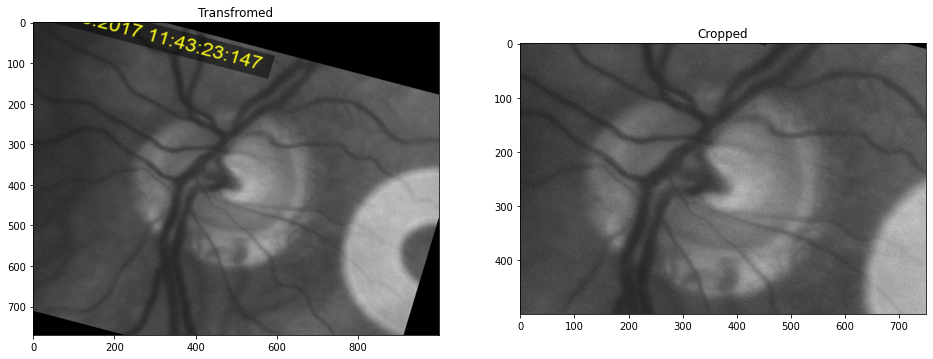

In [34]:
plt.figure(figsize=(16, 9))
#plt.subplot(121)
#plt.imshow(img)
#plt.title('Original')
  
plt.subplot(121)
plt.imshow(trans_img)
plt.title('Transfromed')

plt.subplot(122)
plt.imshow(crop)
plt.title('Cropped')
  
plt.show()

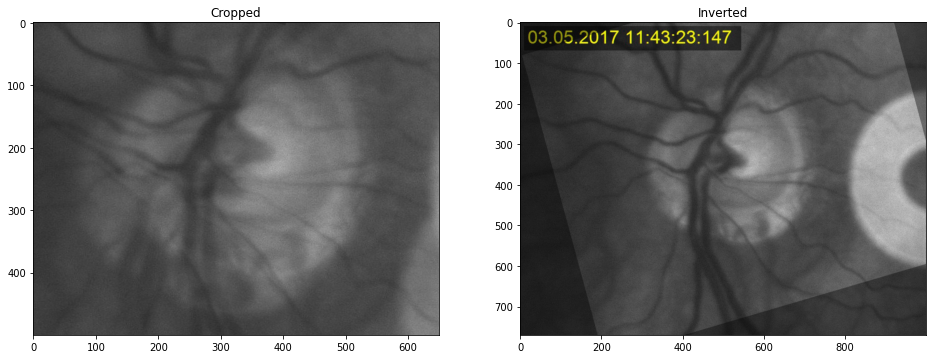

In [27]:
T_opencv_inv = cv2.invertAffineTransform(T_opencv)
trans_img_inv = cv2.warpAffine(trans_img, T_opencv_inv, (cols,rows))


plt.figure(figsize = (16,9))
plt.subplot(121)
plt.title('Cropped')
plt.imshow(img[center[1]-h//2:center[1]+h//2, center[0]-w//2:center[0]+w//2])
plt.imshow(crop, alpha=0.4)

plt.subplot(122)
plt.title('Inverted')
plt.imshow(img)
plt.imshow(trans_img_inv, alpha=0.4)

plt.show()

In [28]:
# Import your picture
input_picture = trans_img
# Color it in gray
gray = cv2.cvtColor(input_picture, cv2.COLOR_BGR2GRAY)

# Create our mask by selecting the non-zero values of the picture
ret, mask = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)

# Select the contour
cont, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# if your mask is incurved or if you want better results, 
# you may want to use cv2.CHAIN_APPROX_NONE instead of cv2.CHAIN_APPROX_SIMPLE, 
# but the rectangle search will be longer

# cv2.drawContours(gray, cont, -1, (255,0,0), 1)
# cv2.imshow("Your picture with contour", gray)
# cv2.waitKey(0)

# Get all the points of the contour
contour = cont[0].reshape(len(cont[0]),2)

# we assume a rectangle with at least two points on the contour gives a 'good enough' result
# get all possible rectangles based on this hypothesis
rect = []

for i in range(len(contour)):
    x1, y1 = contour[i]
    for j in range(len(contour)):
        x2, y2 = contour[j]
        area = abs(y2-y1)*abs(x2-x1)
        rect.append(((x1,y1), (x2,y2), area))

# the first rect of all_rect has the biggest area, so it's the best solution if he fits in the picture
all_rect = sorted(rect, key = lambda x : x[2], reverse = True)

# we take the largest rectangle we've got, based on the value of the rectangle area
# only if the border of the rectangle is not in the black part

# if the list is not empty
if all_rect:

    best_rect_found = False
    index_rect = 0
    nb_rect = len(all_rect)

    # we check if the rectangle is  a good solution
    while not best_rect_found and index_rect < nb_rect:

        rect = all_rect[index_rect]
        (x1, y1) = rect[0]
        (x2, y2) = rect[1]

        valid_rect = True

        # we search a black area in the perimeter of the rectangle (vertical borders)
        x = min(x1, x2)
        while x <max(x1,x2)+1 and valid_rect:
            if mask[y1,x] == 0 or mask[y2,x] == 0:
                # if we find a black pixel, that means a part of the rectangle is black
                # so we don't keep this rectangle
                valid_rect = False
            x+=1

        y = min(y1, y2)
        while y <max(y1,y2)+1 and valid_rect:
            if mask[y,x1] == 0 or mask[y,x2] == 0:
                valid_rect = False
            y+=1

        if valid_rect:
            best_rect_found = True

        index_rect+=1

    if best_rect_found:

        #cv2.rectangle(gray, (x1,y1), (x2,y2), (255,0,0), 1)
        #cv2.imshow("Is that rectangle ok?",gray)
        #cv2.waitKey(0)

        # Finally, we crop the picture and store it
        result = input_picture[min(y1, y2):max(y1, y2), min(x1,x2):max(x1,x2)]
        print(result.shape)

        #cv2.imwrite("Lena_cropped.png",result)
    else:
        print("No rectangle fitting into the area")

else:
    print("No rectangle found")


(551, 927, 3)


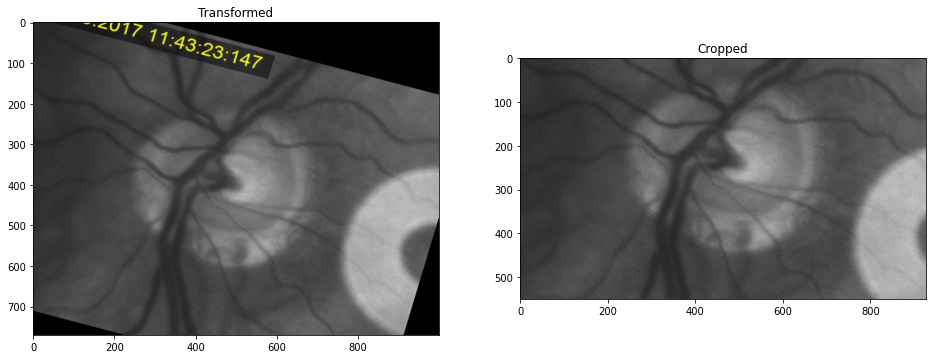

In [29]:
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(trans_img)
plt.title('Transformed')

plt.subplot(122)
plt.imshow(result)
plt.title('Cropped')

plt.show()

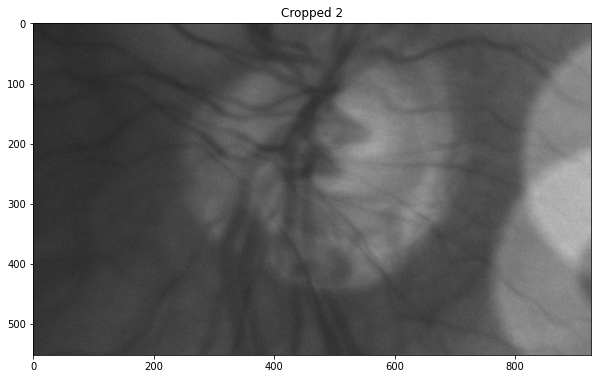

In [30]:
plt.figure(figsize = (10,10))
plt.title('Cropped 2')
plt.imshow(img[min(y1, y2):max(y1, y2), min(x1,x2):max(x1,x2)])
plt.imshow(result, alpha=0.5)
plt.show()

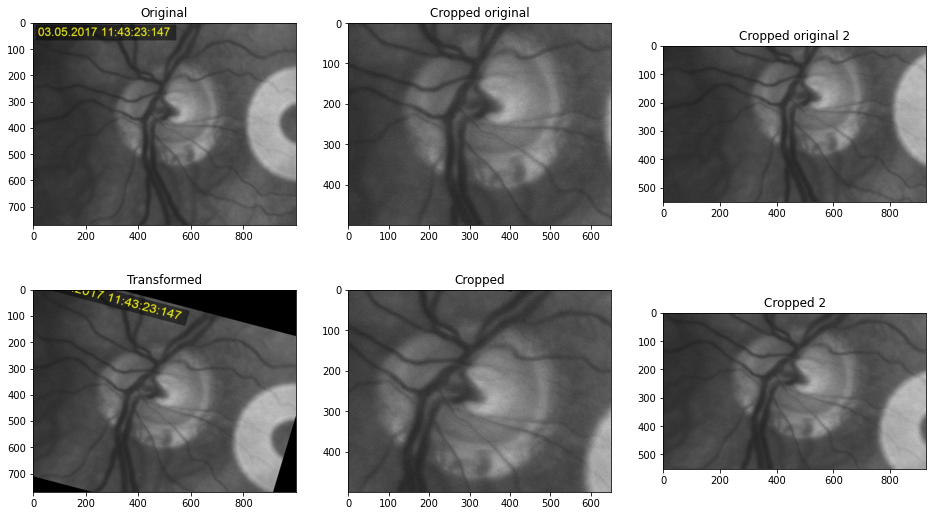

In [31]:
plt.figure(figsize=(16, 9))
plt.subplot(231)
plt.imshow(img)
plt.title('Original')
  
plt.subplot(232)
plt.imshow(img[center[1]-h//2:center[1]+h//2, center[0]-w//2:center[0]+w//2])
plt.title('Cropped original')
    
plt.subplot(233)
plt.imshow(img[min(y1, y2):max(y1, y2), min(x1,x2):max(x1,x2)])
plt.title('Cropped original 2')

plt.subplot(234)
plt.imshow(trans_img)
plt.title('Transformed')
  
plt.subplot(235)
plt.imshow(crop)
plt.title('Cropped')
    
plt.subplot(236)
plt.imshow(result)
plt.title('Cropped 2')
  
plt.show()

In [130]:
np.random.uniform(-2, 2, 1)[0]

0.4887552616773405